# Análisis Exploratorio de Datos COVID-19

> Técnicas Avanzadas de Análisis de Datos

> Daute Rodríguez Rodríguez

## Objetivo

Llevar a cabo un análisis exploratorio de datos sobre el COVID-19 intentando responder preguntas de interés social sobre la pandemia.

## Preparación

Importación de las librerías y utilidades necesarias para la ejecución del código del Notebook.

In [0]:
from datetime import datetime, timedelta, date
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Establecimiento de algunas opciones de formato.

In [0]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set()
warnings.filterwarnings('ignore')

## Integración de datos

### Cifras COVID-19

En la siguiente celda de código se cargan los datos totalizados sobre el COVID-19. Se dispone de cifras sobre:

* Casos (confirmados por PCR)
* Altas médicas
* Fallecidos


In [0]:
casosDf = pd.read_csv('data/ccaa_covid19_casos.csv', parse_dates=['fecha'], usecols=['fecha', 'CCAA', 'total'])
casosDf.rename({'fecha': 'Fecha', 'total': 'Casos'}, axis=1, inplace=True)

altasDf = pd.read_csv('data/ccaa_covid19_altas.csv', parse_dates=['fecha'], usecols=['fecha', 'CCAA', 'total'])
altasDf.rename({'fecha': 'Fecha', 'total': 'Altas'}, axis=1, inplace=True)
altasDf.fillna(0, inplace=True)
altasDf.Altas = altasDf.Altas.astype(int)

fallecidosDf = pd.read_csv('data/ccaa_covid19_fallecidos.csv', parse_dates=['fecha'], usecols=['fecha', 'CCAA', 'total'])
fallecidosDf.rename({'fecha': 'Fecha', 'total': 'Fallecidos'}, axis=1, inplace=True)

print('Datos sobre casos: ', casosDf.Fecha.min().date(), '/', casosDf.Fecha.max().date())
print('Datos sobre altas: ', altasDf.Fecha.min().date(), '/', altasDf.Fecha.max().date())
print('Datos sobre fallecidos: ', fallecidosDf.Fecha.min().date(), '/', fallecidosDf.Fecha.max().date())

Datos sobre casos:  2020-02-21 / 2020-05-17
Datos sobre altas:  2020-02-21 / 2020-05-17
Datos sobre fallecidos:  2020-03-03 / 2020-05-17


Tal y como se indica en la salida de la anterior celda de código, los datos sobre fallecidos abarcan un periodo de tiempo más corto que el resto de datos disponibles. A continuación se intentará solventar este inconveniente. Otro aspecto a tener en cuenta es que los datos están organizados por comunidades autónomas, por lo que habrá que comprobar que se disponga del mismo número de registros por cada una y por cada variable (casos, hospitalizados, ...). En algunos dataframe ha sido necesario imputar valores perdidos, se ha decidido importar por defecto el valor 0, sin embargo, este valor solo será válido para los valores perdidos que no tengan un valor definido previamente (en un día anterior) distinto de 0. Este problema también se abordará a continuación.

Por suerte, todos las cifras sobre fallecidos de las CCAA y ciudades autónomas del día inicial del periodo son igual a 0. Esto significa que se podrán introducir fácilmente los registros faltantes, de manera que se igualen las fechas iniciales de cada variable:

In [0]:
fallecidosDf[fallecidosDf['Fecha'] == pd.Timestamp(2020, 3, 3)]

,Fecha,CCAA,Fallecidos
0,2020-03-03,Andalucía,0
76,2020-03-03,Aragón,0
152,2020-03-03,Asturias,0
228,2020-03-03,Baleares,0
304,2020-03-03,Canarias,0
380,2020-03-03,Cantabria,0
456,2020-03-03,Castilla La Mancha,0
532,2020-03-03,Castilla y León,0
608,2020-03-03,Cataluña,0
684,2020-03-03,Ceuta,0


In [0]:
newValues = []
ccaas = fallecidosDf.CCAA.unique()

baseDate = datetime(2020, 2, 21)
dates = np.array([baseDate + timedelta(days=i) for i in range(11)])

for ccaa in ccaas:
    for date in dates:
        newValues.append({'Fecha': date, 'CCAA': ccaa, 'Fallecidos': 0})

fallecidosDf = fallecidosDf.append(newValues)
fallecidosDf.sort_values(['CCAA', 'Fecha'], inplace=True)
fallecidosDf.reset_index(inplace=True)
fallecidosDf.drop(['index'], axis=1, inplace=True)
fallecidosDf.head()

,Fecha,CCAA,Fallecidos
0,2020-02-21,Andalucía,0
1,2020-02-22,Andalucía,0
2,2020-02-23,Andalucía,0
3,2020-02-24,Andalucía,0
4,2020-02-25,Andalucía,0


A continuación se realiza el merge de todas las variables de las que se dispone hasta el momento:

In [0]:
df = casosDf.merge(fallecidosDf).merge(altasDf)
df.sort_values(['CCAA', 'Fecha'], inplace=True)
df.head()

,Fecha,CCAA,Casos,Fallecidos,Altas
0,2020-02-21,Andalucía,0,0,0
1,2020-02-22,Andalucía,0,0,0
2,2020-02-23,Andalucía,0,0,0
3,2020-02-24,Andalucía,0,0,0
4,2020-02-25,Andalucía,0,0,0


Resta comprobar que los datos cumplen una restricción. Al ser datos totalizados, no es posible que la cifra de un día sea menor que la del día anterior. La salida de la siguiente celda de código muestra que la restricción se incumple en varias ocasiones y en distintas CCAA.

In [0]:
columns = ['Casos', 'Fallecidos', 'Altas']

for ccaa in ccaas:
    for column in columns:
        data = df[df['CCAA'] == ccaa][column]
        diff = (data - data.shift(fill_value=0))
        check = (diff >= 0)
        if (not check.all().all()):
            index = check[~ check].index
            data[index][column] = np.NaN
            print('Restricción incumplida en', len(index), 'ocasión/es para la variable', column, 'en', ccaa)

Restricción incumplida en 1 ocasión/es para la variable Altas en Ceuta


En la siguiente gráfica puede verse que el único caso en el que se incumple la restricción anteriormente comentada es el 21 de Abril de 2020 en la ciudad autónoma de Ceuta con las altas hospitalarias:

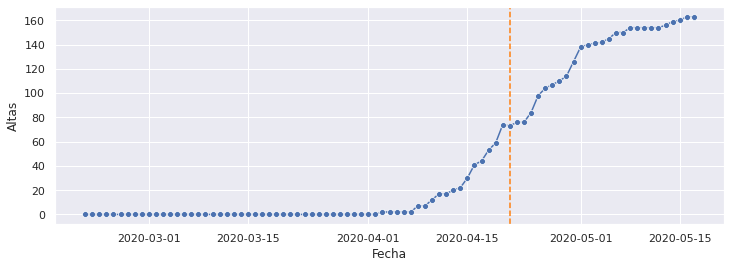

In [0]:
mask = df['CCAA'] == 'Ceuta'
plt.figure(figsize=(12, 4))
plt.axvline(datetime(2020, 4, 21), color='tab:orange', ls='--')
sns.lineplot(x='Fecha', y='Altas', data=df[mask], marker='o');

In [0]:
mask &= (df['Fecha'] < datetime(2020, 4, 23)) & (df['Fecha'] > datetime(2020, 4, 19))
df[mask]

,Fecha,CCAA,Casos,Fallecidos,Altas
842,2020-04-20,Ceuta,114,4,74
843,2020-04-21,Ceuta,114,4,73
844,2020-04-22,Ceuta,124,4,76


Como puede verse en la salida de la anterior celda, parece que hubo un fallo a la hora de introducir este dato. Se llevará a cabo la sustitición del valor erróneo por la media del día anterior y del día siguiente:

In [0]:
mask = (df['CCAA'] == 'Ceuta') & (df['Fecha'] == datetime(2020, 4, 21))
df.loc[mask, 'Altas'] = 75
mask = (df['CCAA'] == 'Ceuta') & (df['Fecha'] < datetime(2020, 4, 23)) & (df['Fecha'] > datetime(2020, 4, 19))
df[mask]

,Fecha,CCAA,Casos,Fallecidos,Altas
842,2020-04-20,Ceuta,114,4,74
843,2020-04-21,Ceuta,114,4,75
844,2020-04-22,Ceuta,124,4,76


A partir de los datos totalizados es posible obtener la cantidad diaria añadida a cada una de las variables:

In [0]:
for ccaa in ccaas:
    data = df.loc[df['CCAA'] == ccaa, ['Casos', 'Fallecidos', 'Altas']].copy()
    diff = data.diff()
    diff.iloc[0] = data.iloc[0]
    df.loc[df['CCAA'] == ccaa, 'Casos/d'] = diff['Casos']
    df.loc[df['CCAA'] == ccaa, 'Fallecidos/d'] = diff['Fallecidos']
    df.loc[df['CCAA'] == ccaa, 'Altas/d'] = diff['Altas']

df['Casos/d'] = df['Casos/d'].astype(int)
df['Fallecidos/d'] = df['Fallecidos/d'].astype(int)
df['Altas/d'] = df['Altas/d'].astype(int)
df.head()

,Fecha,CCAA,Casos,Fallecidos,Altas,Casos/d,Fallecidos/d,Altas/d
0,2020-02-21,Andalucía,0,0,0,0,0,0
1,2020-02-22,Andalucía,0,0,0,0,0,0
2,2020-02-23,Andalucía,0,0,0,0,0,0
3,2020-02-24,Andalucía,0,0,0,0,0,0
4,2020-02-25,Andalucía,0,0,0,0,0,0


Por último, se añadirá un posible valor al atributo CCAA que simbolice el total agregado de todas las CCAA:

In [0]:
total = df.groupby(['Fecha']).sum().copy()
total['CCAA'] = 'Total'
total.reset_index(inplace=True)
df = df.append(total).reset_index(drop=True).sort_values(['CCAA', 'Fecha'])
df.CCAA = df.CCAA.astype('category')
df.tail()

,Fecha,CCAA,Casos,Fallecidos,Altas,Casos/d,Fallecidos/d,Altas/d
1735,2020-05-13,Total,271382,27106,140823,1519,183,1843
1736,2020-05-14,Total,272577,27323,143374,1195,217,2551
1737,2020-05-15,Total,274398,27461,144783,1821,138,1409
1738,2020-05-16,Total,276726,27563,146857,2328,102,2074
1739,2020-05-17,Total,277719,27650,149576,993,87,2719


In [0]:
originalDf = df.copy()

### Datos sobre movilidad de la población

Carga de datos de movilidad de la población, [ofrecidos por Google](https://www.google.com/covid19/mobility/index.html?hl=es). Muestran los cambios de los desplazamientos en España a raíz de la emergencia sanitaria sufrida. Obtenidos a partir del uso de Google Maps, estos datos proporcionan información valiosa sobre los cambios que se han producido en la movilidad de las personas como consecuencia de las políticas que se han establecido para combatir el COVID‑19. Muestran las tendencias de movimiento a lo largo del tiempo clasificadas en diversas categorías de lugares, como comercios y espacios de ocio, supermercados y farmacias, parques, estaciones de transporte público, lugares de trabajo y zonas residenciales. Los valores indican la diferencia porcentual de la movilidad a un cierto tipo de lugar en comparación con datos previos a la pandemia. Los datos de los que se disponen abarcan desde el 15 de Febrero de 2020 hasta el 09 de Mayo de 2020.

In [0]:
mobilityDf = pd.read_csv('data/mobility.csv', parse_dates=['date'])
mobilityDf = mobilityDf[mobilityDf['country_region'] == 'Spain']
mobilityDf.drop(['country_region', 'country_region_code', 'sub_region_2'], axis=1, inplace=True)
mobilityDf.rename({
    'sub_region_1': 'CCAA', 'date': 'Fecha', 
    'retail_and_recreation_percent_change_from_baseline': 'Movilidad Ocio/Entretenimiento',
    'grocery_and_pharmacy_percent_change_from_baseline': 'Movilidad Comida/Farmacia',
    'parks_percent_change_from_baseline': 'Movilidad Parques',
    'transit_stations_percent_change_from_baseline': 'Movilidad Estaciones',
    'workplaces_percent_change_from_baseline': 'Movilidad Lugares de trabajo',
    'residential_percent_change_from_baseline': 'Movilidad Residencias'
}, axis=1, inplace=True)
mobilityDf.CCAA.replace({
    'Region of Murcia': 'Murcia', 'Valencian Community': 'C. Valenciana', 
    'Community of Madrid': 'Madrid', 'Basque Country': 'País Vasco', 'Navarre': 'Navarra', 
    'Catalonia': 'Cataluña', 'Balearic Islands': 'Baleares', 'Andalusia': 'Andalucía',
    'Aragon': 'Aragón', 'Canary Islands': 'Canarias', 'Castile-La Mancha': 'Castilla La Mancha', 
    'Castile and León': 'Castilla y León'
}, inplace=True)

mobilityDf.CCAA.fillna('Total', inplace=True)
mobilityDf.sort_values(['CCAA', 'Fecha'], inplace=True)
mobilityDf.reset_index(drop=True, inplace=True)
mobilityDf.head()

,CCAA,Fecha,Movilidad Ocio/Entretenimiento,Movilidad Comida/Farmacia,Movilidad Parques,Movilidad Estaciones,Movilidad Lugares de trabajo,Movilidad Residencias
0,Andalucía,2020-02-15,5.000,-1.000,33.000,15.000,0.000,-2.000
1,Andalucía,2020-02-16,6.000,4.000,17.000,10.000,1.000,-4.000
2,Andalucía,2020-02-17,0.000,0.000,10.000,8.000,4.000,-1.000
3,Andalucía,2020-02-18,-1.000,0.000,6.000,7.000,4.000,-1.000
4,Andalucía,2020-02-19,0.000,0.000,7.000,6.000,3.000,0.000


Al parecer, existen numerosos valores perdidos para las ciudades autónomas Ceuta y Melilla. Se sustutirán por los valores totales de España para el mismo día:

In [0]:
mobilityDf.isna().sum()

CCAA                                0
Fecha                               0
Movilidad Ocio/Entretenimiento      0
Movilidad Comida/Farmacia           7
Movilidad Parques                   0
Movilidad Estaciones              109
Movilidad Lugares de trabajo        0
Movilidad Residencias             131
dtype: int64

In [0]:
columnsWithNan = ['Movilidad Comida/Farmacia', 'Movilidad Estaciones', 'Movilidad Residencias']

totalValues = mobilityDf.loc[mobilityDf['CCAA'] == 'Total'].copy()
totalValues.set_index('Fecha', inplace=True)

def FillNaN(row, column):
    if pd.isnull(row[column]):
        row[column] = totalValues.loc[row['Fecha']][column]
    return row
    
for column in columnsWithNan:
    mobilityDf = mobilityDf.apply(lambda row: FillNaN(row, column), axis=1)
    
mobilityDf.isna().sum()

CCAA                              0
Fecha                             0
Movilidad Ocio/Entretenimiento    0
Movilidad Comida/Farmacia         0
Movilidad Parques                 0
Movilidad Estaciones              0
Movilidad Lugares de trabajo      0
Movilidad Residencias             0
dtype: int64

Cabe destacar que los datos sobre movilidad de la población abarcan hasta el 9 de Mayo de 2020. Se trata de un periodo de tiempo menor al de los datos sobre casos, fallecidos y altas del COVID-19 por lo que resulta necesario reducir el tamaño del periodo bajo estudio.

In [0]:
df = df.merge(mobilityDf)
df.CCAA = df.CCAA.astype('category')
df.head()

,Fecha,CCAA,Casos,Fallecidos,Altas,Casos/d,Fallecidos/d,Altas/d,Movilidad Ocio/Entretenimiento,Movilidad Comida/Farmacia,Movilidad Parques,Movilidad Estaciones,Movilidad Lugares de trabajo,Movilidad Residencias
0,2020-02-21,Andalucía,0,0,0,0,0,0,3.000,0.000,14.000,11.000,4.000,-1.000
1,2020-02-22,Andalucía,0,0,0,0,0,0,4.000,2.000,38.000,22.000,3.000,-2.000
2,2020-02-23,Andalucía,0,0,0,0,0,0,10.000,14.000,28.000,24.000,3.000,-3.000
3,2020-02-24,Andalucía,0,0,0,0,0,0,4.000,1.000,28.000,13.000,-1.000,-1.000
4,2020-02-25,Andalucía,0,0,0,0,0,0,3.000,5.000,19.000,11.000,1.000,-1.000


### Población de cada comunidad autónoma

En la siguiente celda de código se añade una nueva variable a los registros del dataframe con el total de población de cada comunidad y ciudad autónoma (datos de 2019):

In [0]:
population = {
    'Andalucía': 8414240, 'Aragón': 1319291, 'Asturias': 1022800,
    'Baleares': 1149460, 'Canarias': 2153389, 'Cantabria': 581078,
    'Castilla y León': 2399548, 'Castilla La Mancha': 2032863, 'Cataluña': 7675217,
    'C. Valenciana': 5003769, 'Extremadura': 1067710, 'Galicia': 2699499,
    'Madrid': 6663394, 'Murcia': 1493898, 'Navarra': 654214,
    'País Vasco': 2207776, 'La Rioja': 316798, 'Ceuta': 84777, 
    'Melilla': 86487, 'Total': 47100396
}

df['Población'] = 0

for ccaa in df.CCAA.cat.categories:
    df.loc[df['CCAA'] == ccaa, 'Población'] = population[ccaa]

### Variables auxiliares

A continuación se declararán algunas variables auxiliares:

In [0]:
firstDay = df.Fecha.min()
stateOfAlarm = datetime(2020, 3, 14)
nonEssentialActivity = datetime(2020, 3, 28)
lastDay = df.Fecha.max()

## Análisis exploratorio

### Poblacíon por CCAA

Para comenzar el análisis exploratorio se visualizará el total de población de cada municipio según los datos obtenidos (año 2019):

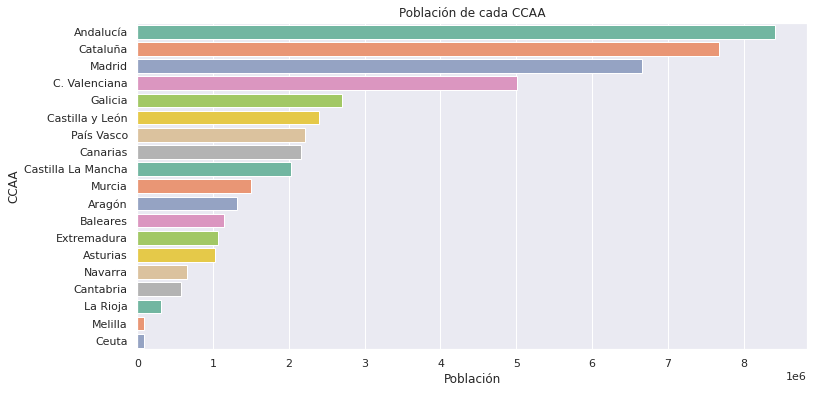

In [0]:
data = df.loc[(df['Fecha'] == firstDay) & (df['CCAA'] != 'Total'), ['CCAA', 'Población']]
plt.figure(figsize=(12, 6))
plt.title('Población de cada CCAA')
sns.barplot(x='Población', y='CCAA', data=data, order=data.sort_values('Población', ascending=False).CCAA, palette=sns.color_palette("Set2", 20));

### Evolución de casos, fallecidos y altas a nivel nacional

A continuación se muestra la evolución de casos, fallecidos y altas hospitalarias totales y por día producidas en España entre los días 21 de Febrero de 2020 y 9 de Mayo de 2020. A la figura con la evolución de estos 3 indicadores se ha añadido una línea discontinua vertical azul indicando el comienzo del estado de alarma y otra violeta indicando la suspensión de la actividad no esencial:

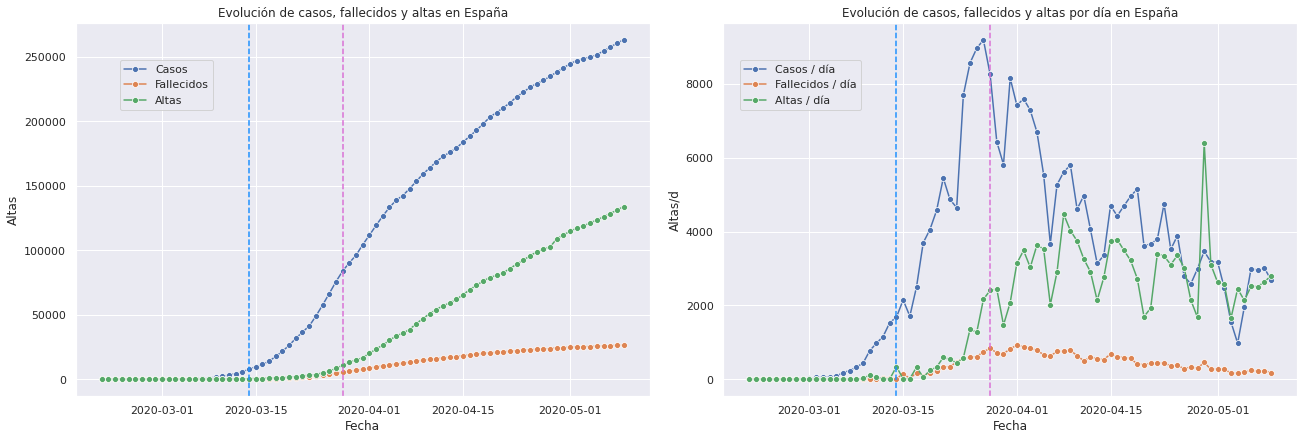

In [0]:
data = df[df['CCAA'] == 'Total']

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(18, 6))

sns.lineplot(x='Fecha', y='Casos', data=data, ax=axs[0], marker='o')
sns.lineplot(x='Fecha', y='Fallecidos', data=data, ax=axs[0], marker='o')
sns.lineplot(x='Fecha', y='Altas', data=data, ax=axs[0], marker='o')
axs[0].axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs[0].axvline(nonEssentialActivity, color='orchid', ls='--')
axs[0].legend(labels=['Casos', 'Fallecidos', 'Altas'], bbox_to_anchor=(0.24, 0.9), borderaxespad=0);
axs[0].set_title('Evolución de casos, fallecidos y altas en España');

sns.lineplot(x='Fecha', y='Casos/d', data=data, ax=axs[1], marker='o')
sns.lineplot(x='Fecha', y='Fallecidos/d', data=data, ax=axs[1], marker='o')
sns.lineplot(x='Fecha', y='Altas/d', data=data, ax=axs[1], marker='o')
axs[1].axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs[1].axvline(nonEssentialActivity, color='orchid', ls='--')
axs[1].legend(labels=['Casos / día','Fallecidos / día','Altas / día'], bbox_to_anchor=(0.24, 0.9), borderaxespad=0);
axs[1].set_title('Evolución de casos, fallecidos y altas por día en España');

Por último, se visualizará el cambio diario suavizado (media móvil con ventana de 2 semanas):

In [0]:
def GetMovingAverage(df, variable, windowSize):
    return df[variable].rolling(window=windowSize)\
            .mean()\
            .iloc[windowSize - 1:]

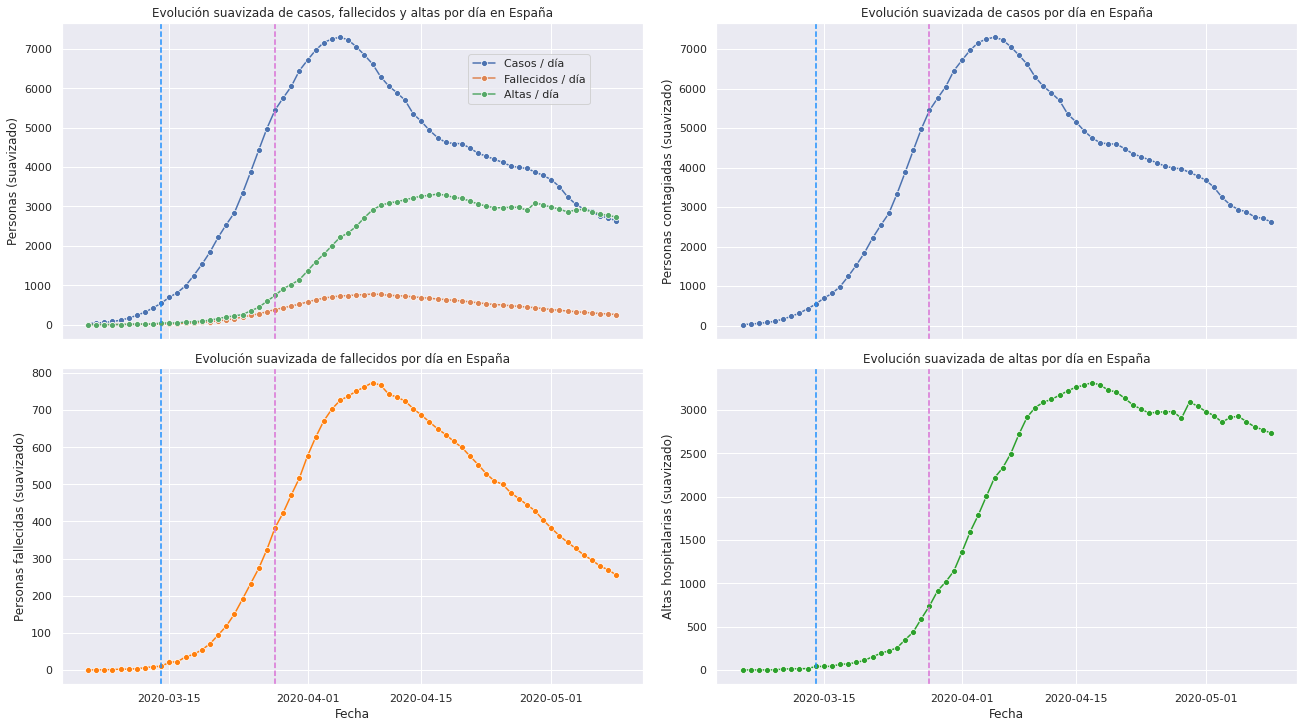

In [0]:
windowSize = 14

data = df[df['CCAA'] == 'Total'].copy()
data['CasosSmooth'] = GetMovingAverage(data, 'Casos/d', windowSize)
data['FallecidosSmooth'] = GetMovingAverage(data, 'Fallecidos/d', windowSize)
data['AltasSmooth'] = GetMovingAverage(data, 'Altas/d', windowSize)


fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(18, 10), sharex=True)
sns.lineplot(x='Fecha', y='CasosSmooth', data=data, ax=axs[0][0], marker='o')
sns.lineplot(x='Fecha', y='FallecidosSmooth', data=data, ax=axs[0][0], marker='o')
sns.lineplot(x='Fecha', y='AltasSmooth', data=data, ax=axs[0][0], marker='o')
axs[0][0].axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs[0][0].axvline(nonEssentialActivity, color='orchid', ls='--')
axs[0][0].set_ylabel('Personas (suavizado)')
axs[0][0].legend(labels=['Casos / día','Fallecidos / día','Altas / día'], bbox_to_anchor=(0.7, 0.9), borderaxespad=0);
axs[0][0].set_title('Evolución suavizada de casos, fallecidos y altas por día en España');

sns.lineplot(x='Fecha', y='CasosSmooth', data=data, ax=axs[0][1], marker='o')
axs[0][1].axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs[0][1].axvline(nonEssentialActivity, color='orchid', ls='--')
axs[0][1].set_ylabel('Personas contagiadas (suavizado)')
axs[0][1].set_title('Evolución suavizada de casos por día en España');

sns.lineplot(x='Fecha', y='FallecidosSmooth', data=data, ax=axs[1][0], marker='o', color='tab:orange')
axs[1][0].axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs[1][0].axvline(nonEssentialActivity, color='orchid', ls='--')
axs[1][0].set_ylabel('Personas fallecidas (suavizado)')
axs[1][0].set_title('Evolución suavizada de fallecidos por día en España');

sns.lineplot(x='Fecha', y='AltasSmooth', data=data, ax=axs[1][1], marker='o', color='tab:green')
axs[1][1].axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs[1][1].axvline(nonEssentialActivity, color='orchid', ls='--')
axs[1][1].set_ylabel('Altas hospitalarias (suavizado)')
axs[1][1].set_title('Evolución suavizada de altas por día en España');

Atendiendo a las visualizaciones es posible concluir que, por suerte, "el pico de la curva" se alcanzó en torno al 7 de Abril de 2020. Las altas hospitalarias se siguen sucediendo a un buen ritmo y los contagios llevan una tendencia negativa.

### Evolución de casos, fallecidos y altas por CCAA

En esta sección del análisis, se visualizarán el total de casos, fallecidos y altas médicas de cada comunidad autónoma y ciudad autónoma a lo largo del periodo bajo estudio. Al tratarse de 19 localidades, se presentarán 4 gráficos por cada variable. También se añadirá en cada subplot una línea discontinua vertical azul indicando el comienzo del estado de alarma y otra violeta indicando la suspensión de la actividad no esencial:

In [0]:
data = df[df['CCAA'] != 'Total']

In [0]:
def PlotTopN(data, n, variable, exclude, ax, lastDate=lastDay, showStateOfAlarmStart=True, showNonEssentialActivityStart=True):
    mask = (data['Fecha'] == lastDay) & (~ data['CCAA'].isin(exclude))
    ccaas = list(data[mask].nlargest(n - len(exclude), variable).CCAA.values)
    data = data[data['CCAA'].isin(ccaas) & (data['Fecha'] <= lastDate)]
    sns.lineplot(x='Fecha', y=variable, hue='CCAA', data=data, ax=ax, marker='o')
    if showStateOfAlarmStart:
        ax.axvline(stateOfAlarm, color='dodgerblue', ls='--')
    if showNonEssentialActivityStart:
        ax.axvline(nonEssentialActivity, color='orchid', ls='--')
    return ccaas

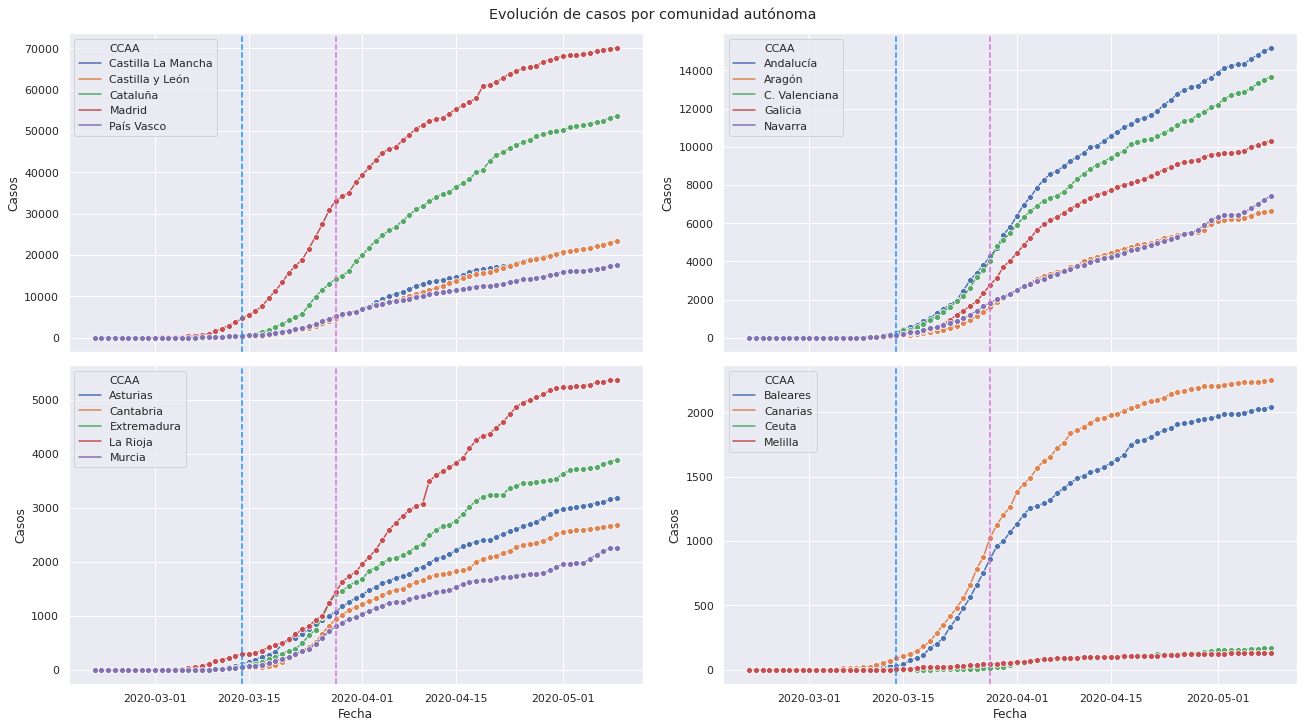

In [0]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(18, 10), sharex=True)
plt.suptitle('Evolución de casos por comunidad autónoma')
alreadyPlotted = PlotTopN(data, 5, 'Casos',  [], axs[0][0])
alreadyPlotted += PlotTopN(data, 10, 'Casos',  alreadyPlotted, axs[0][1])
alreadyPlotted += PlotTopN(data, 15, 'Casos',  alreadyPlotted, axs[1][0])
alreadyPlotted += PlotTopN(data, 19, 'Casos',  alreadyPlotted, axs[1][1])

Como puede apreciarse, existe una gran diferencia entre las regiones que menos casos tienen y las que más. El virus ha afectado con mayor gravedad a Madrid, Cataluña, Castilla y León, Castilla La Mancha y País Vasco. Llama la atención que una comunidad como Andalucía (la más poblada del país) no se encuentre entre las 5 con mayor número de casos (ocupa la sexta posición). De esta observación se puede extraer que es importante estudiar la proporción de casos y fallecidos frente a la población total de la región estudiada. No es casualidad que las 4 regiones con menor número de casos sean aquellas más "aisladas", es decir, Baleares, Canarias, Ceuta y Melilla.

Las siguientes figuras muestran la evolución de casos en las 5 CCAA más afectadas hasta el comienzo del estado de alarma (izquierda) y la suspensión de la actividad no esencial (derecha). En dichas gráficas puede verse cómo la situación en estas CCAA (especialmente en Madrid y Cataluña), era bastante grave antes de que se tomaran las ya comentadas medidas:

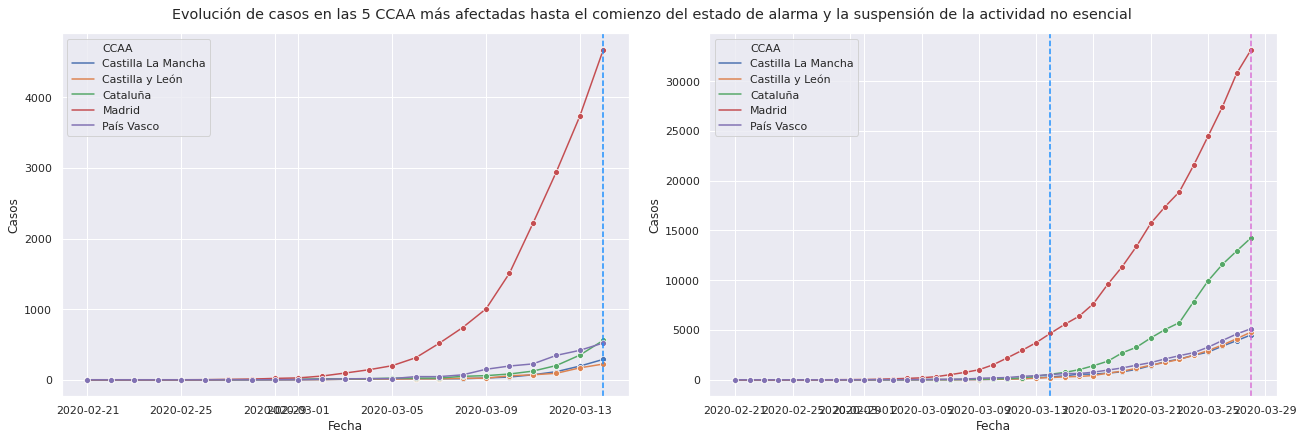

In [0]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(18, 6))
plt.suptitle('Evolución de casos en las 5 CCAA más afectadas hasta el comienzo del estado de alarma y la suspensión de la actividad no esencial')
alreadyPlotted = PlotTopN(data, 5, 'Casos',  [], axs[0], stateOfAlarm, True, False)
alreadyPlotted = PlotTopN(data, 5, 'Casos',  [], axs[1], nonEssentialActivity)

A continuación se muestra la evolución de fallecidos por comunidad autónoma. Como puede verse, muestra un comportamiento similar a la evolución de casos. Las diferencias de posición pueden dejar entrever las diferencias de capacidad de los servicios sanitarios entre las CCAA.

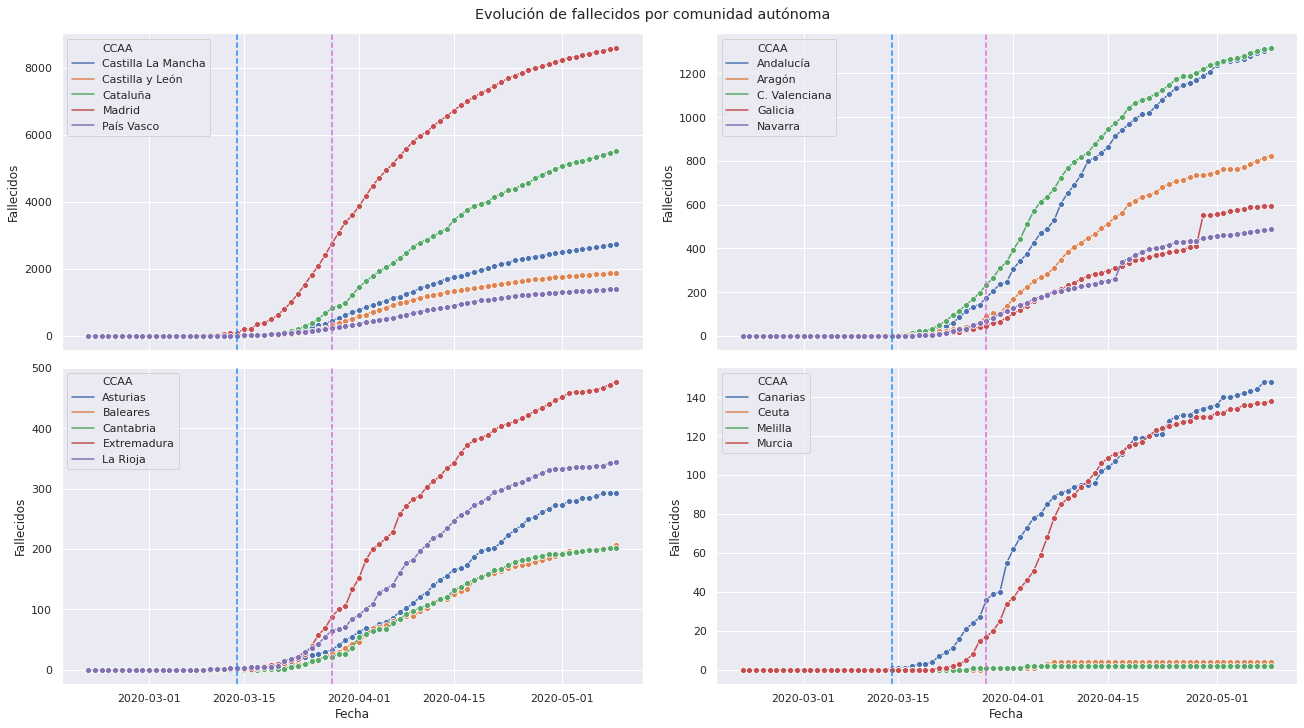

In [0]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(18, 10), sharex=True)
plt.suptitle('Evolución de fallecidos por comunidad autónoma')
alreadyPlotted = PlotTopN(data, 5, 'Fallecidos',  [], axs[0][0])
alreadyPlotted += PlotTopN(data, 10, 'Fallecidos',  alreadyPlotted, axs[0][1])
alreadyPlotted += PlotTopN(data, 15, 'Fallecidos',  alreadyPlotted, axs[1][0])
alreadyPlotted += PlotTopN(data, 19, 'Fallecidos',  alreadyPlotted, axs[1][1])

Por último, se muestra la evolución de las altas hospitalarias por cada comunidad autónoma, así como la proporción de casos que han recibido el alta el día 9 de Mayo:

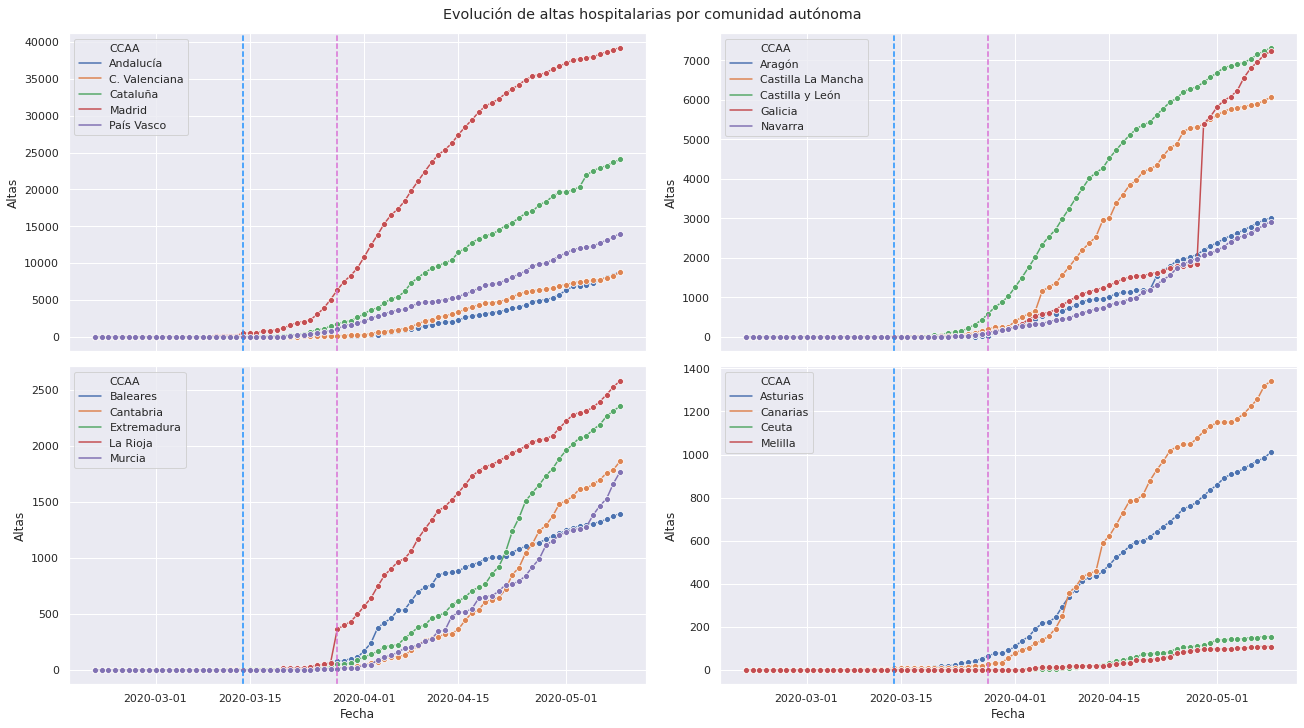

In [0]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(18, 10), sharex=True)
plt.suptitle('Evolución de altas hospitalarias por comunidad autónoma')
alreadyPlotted = PlotTopN(data, 5, 'Altas',  [], axs[0][0])
alreadyPlotted += PlotTopN(data, 10, 'Altas',  alreadyPlotted, axs[0][1])
alreadyPlotted += PlotTopN(data, 15, 'Altas',  alreadyPlotted, axs[1][0])
alreadyPlotted += PlotTopN(data, 19, 'Altas',  alreadyPlotted, axs[1][1])

In [0]:
data = df[df['Fecha'] == lastDay].copy()
data['Altas/Casos'] = data['Altas'] / data['Casos'] * 100

data[['Altas/Casos', 'CCAA']].nlargest(3, 'Altas/Casos')

,Altas/Casos,CCAA
868,91.124,Ceuta
1263,81.818,Melilla
1500,79.673,País Vasco


In [0]:
data[['Altas/Casos', 'CCAA']].nsmallest(3, 'Altas/Casos')

,Altas/Casos,CCAA
631,26.025,Castilla La Mancha
710,31.200,Castilla y León
236,31.794,Asturias


A partir de la información mostrada se pueden extraer una serie de particularidades:

* El recuento de fallecidos y altas en Galicia parece haber sufrido un cambio significativo en torno al día 27 de Abril. Ambas líneas de puntos presentan un crecimiento bastante amplio, sobretodo la de altas hospitalarias.
* Las CCAA con menor porcentaje de altas hospitalarias frente a los casos diagnosticados son Castilla La Mancha (26%), Castilla y León (31%) y Asturias (31%). Por otro lado, las ciudades autónomas (Ceuta 91%, Melilla 81%) y el País Vasco (79%) son las regiones con mayor porcentaje de altas. Que las ciudades autónomas tengan un alto porcentaje era de esperar, puesto que la velocidad de contagios se ha reducido drásticamente en ambas.

### Porcentajes de población contagiada y fallecida

En esta sección se visualizarán los porcentajes de población contagiada y fallecida en cada comunidad autónoma. Además, se presentará también el porcentaje de fallecidos entre los contagiados. Cabe destacar que estos porcentajes se corresponden con los datos de la fecha final del periodo bajo estudio, es decir, el 9 de Mayo de 2020. La línea discontinua marca el porcentaje medio ponderado a nivel nacional:

In [0]:
data = df[df['Fecha'] == lastDay].copy()[['CCAA', 'Casos', 'Fallecidos', 'Población']]
data['%Casos'] = (data['Casos'] / data['Población']) * 100
data['%Fallecidos'] = (data['Fallecidos'] / data['Población']) * 100
data['%Fallecidos/Casos'] = (data['Fallecidos'] / data['Casos']) * 100
data.drop(['Casos', 'Fallecidos'], inplace=True, axis=1)
data.set_index('CCAA', inplace=True)

values = []

for ccaa in df.CCAA.cat.categories:
    row = data.loc[ccaa]
    values.append({'CCAA': ccaa, 'Medida': '% Casos', 'Valor': row['%Casos']})
    values.append({'CCAA': ccaa, 'Medida': '% Fallecidos', 'Valor': row['%Fallecidos']})
    values.append({'CCAA': ccaa, 'Medida': '% Fallecidos / Casos', 'Valor': row['%Fallecidos/Casos']})

data = pd.DataFrame(values, columns=['CCAA', 'Medida', 'Valor'])
data.CCAA = data.CCAA.astype('category')

In [0]:
def PlotVariable(variable, title=''):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    newData = data[data['Medida'] == variable]
    sns.barplot(x='Valor', y='CCAA', data=newData, order=newData.sort_values('Valor').CCAA, palette=sns.color_palette("Set2", 20))
    plt.axvline(newData.loc[newData['CCAA'] == 'Total', 'Valor'].values[0], color='dodgerblue', ls='--');

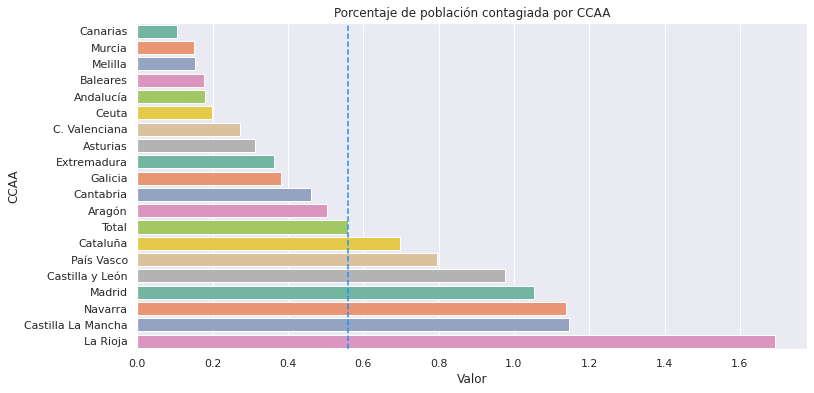

In [0]:
PlotVariable('% Casos', 'Porcentaje de población contagiada por CCAA')

* La CCAA con mayor porcentaje de población contagiada es La Rioja, seguida de Castilla La Mancha, Navarra y Madrid.
* La CCAA con menor porcentaje de población contagiada es Canarias, seguida de Murcia, la ciudad autónoma de Melilla y Baleares.
* El porcentaje medio a nivel nacional es próximo al 0.55 %.

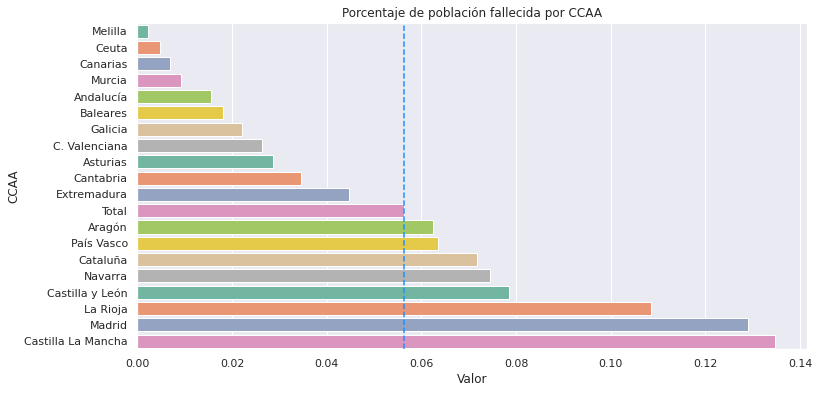

In [0]:
PlotVariable('% Fallecidos', 'Porcentaje de población fallecida por CCAA')

* La CCAA con mayor porcentaje de población fallecida es Castilla La Mancha, seguida de Madrid, La Rioja y Castilla y León.
* Las ciudades autónomas son las regiones que presentan el porcentaje de población fallecida más bajo, seguidas por Canarias y Murcia.
* El porcentaje medio a nivel nacional es próximo al 0.055 %.

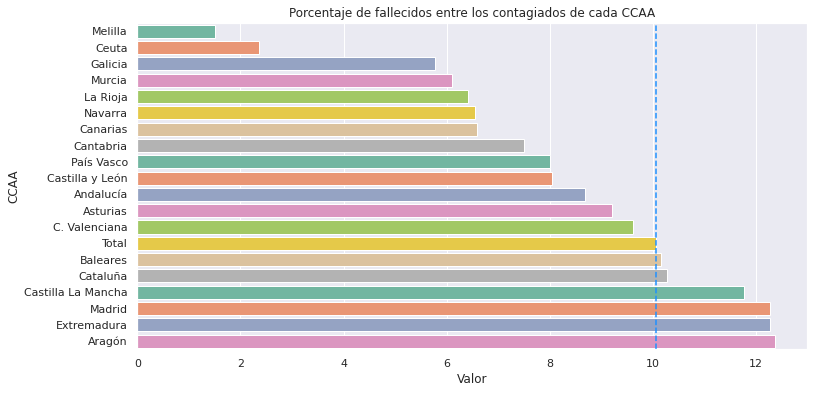

In [0]:
PlotVariable('% Fallecidos / Casos', 'Porcentaje de fallecidos entre los contagiados de cada CCAA')

* La CCAA con mayor porcentaje de fallecidos entre los contagiados es Aragón, seguida de Extremadura, Madrid y Castilla La Mancha.
* Las ciudades autónomas son las regiones que presentan el porcentaje de fallecidos frente a contagios más bajo, seguidas por Galicia y Murcia.
* El porcentaje medio a nivel nacional es próximo al 10 %.

### Datos de movilidad frente al número de casos diarios

En esta sección del notebook se va a estudiar la relación entre los nuevos casos diarios y los datos sobre movilidad de la población. Por simplicidad, se utilizarán únicamente los datos a nivel nacional. En principio, cabría esperar que los datos de movilidad sufrieran una caída de valores bastante notable a partir de la declaración del estado de alarma y el consiguiente confinamiento. A priori, se supone que la cantidad de contagios diarios también debería reducirse como efecto del confinamiento. A continuación se visualiza la evolución de las diferencias porcentuales (diferencias con respecto a datos previos a la pandemia) para distintos tipos de movilidad:

In [0]:
data = df[df['CCAA'] == 'Total']
mobilityVariables = ['Movilidad Ocio/Entretenimiento', 'Movilidad Comida/Farmacia', 'Movilidad Parques', 'Movilidad Estaciones', 'Movilidad Lugares de trabajo', 'Movilidad Residencias']

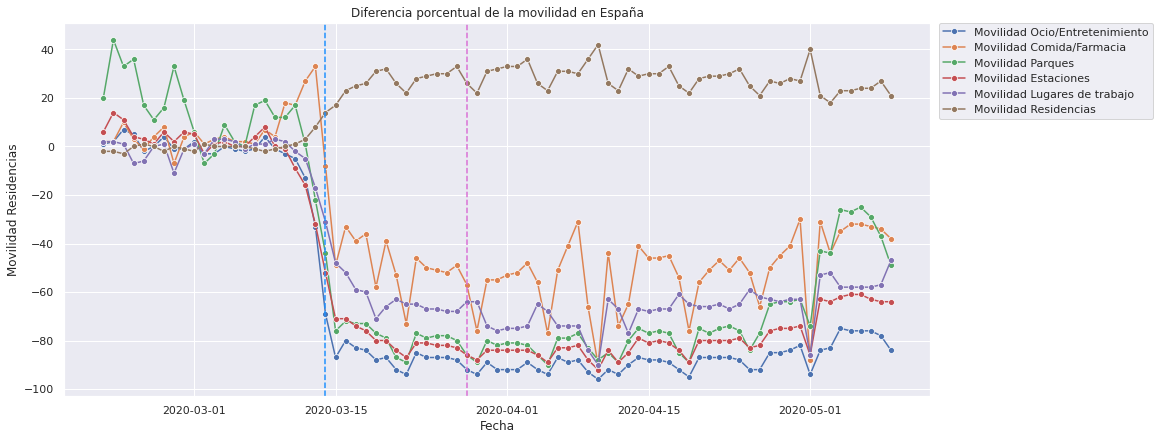

In [0]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(16, 6))
axs.set_ylabel('Diferencia porcentual')
axs.set_title('Diferencia porcentual de la movilidad en España');

for variable in mobilityVariables:
    sns.lineplot(x='Fecha', y=variable, data=data, ax=axs, marker='o')
axs.legend(labels=mobilityVariables, bbox_to_anchor=(1.01, 1), borderaxespad=0)
axs.axvline(stateOfAlarm, color='dodgerblue', ls='--')
axs.axvline(nonEssentialActivity, color='orchid', ls='--');

Como era de esperar, se puede advertir un gran descenso en la mayoría de tipos de movilidad tras la declaración del estado de alarma. En contraposición, la movilidad hacia zonas de residencia aumentó de manera significativa. Esto puede deberse a numerosos factores cómo:

* Ayuda a personas de grupos de riesgo: Mucha gente tuvo que hacer y llevar la compra a personas mayores, con movilidad reducida o con enfermedades crónicas (especialmente vulnerables).
* Trayectos más directos: Los movimientos de los ciudadanos se reducen a los indispensables, sin paradas innecesarias.

Dentro de los tipos de movilidad que sufrieron un gran descenso en sus valores, la movilidad hacia lugares de compra de comida y a farmacias es la que menos diferencia sufrió. Esto corrobora la afirmación hecha anteriormente: las personas realizaron los mínimos movimientos necesarios (abastecimiento). El repunte de movimientos a parques puede deberse a las medidas adoptadas por el Gobierno para que los más pequeños pudieran salir en ciertos horarios. El tipo de movimiento más afectado es el dirigido a lugares de ocio y entretenimiento.

A priori, el confinamiento y la disminución de movilidad de la población deberían afectar negativamente a la cantidad de contagios diarios. Aunque atendiendo a la siguiente matriz de correlaciones parece ocurrir lo contrario:

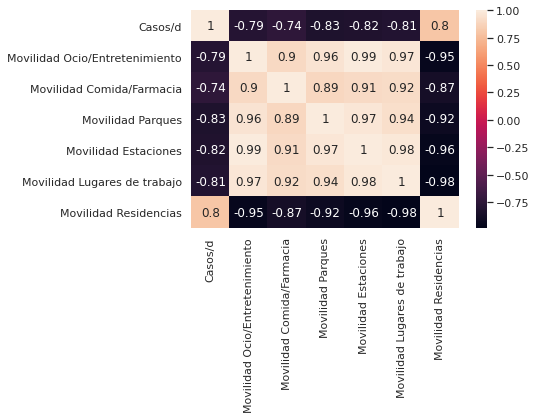

In [0]:
data = df[df['CCAA'] == 'Total'].copy()
data.drop(['Fecha', 'CCAA', 'Casos', 'Fallecidos', 'Altas', 'Población', 'Fallecidos/d', 'Altas/d'], inplace=True, axis=1)

corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True);

A partir de los valores mostrados, se pueden obtener varias conclusiones. Cabe destacar que las afirmaciones que se realicen han de contextualizarse a los datos de los que se dispone, es decir, son datos que en menor o mayor medida están afectados por la situación provocada por la pandemia:

* Todos los tipos de movilidad tienen una alta correlación positiva entre ellos exceptuando la movilidad a lugares de residencia. Esto se debe a la declaración del estado de alarma, en la gráfica anterior puede verse cómo mientras todos los tipos de movilidad se redujeron, la movilidad a lugares residenciales aumentó.
* Según los valores de correlaciones, el tipo de movilidad que más afecta al número de casos diarios es la movilidad a lugares residenciales. Todos los demás tipos de movilidad mantienen una correlación negativa fuerte con la variable de los casos diarios. Es decir, cuando más grande es la movilidad a lugares públicos de ocio y entretenimiento, más bajan los contagios diarios. Obviamente esto no es así, es precisamente al contrario.
* En definitiva, intentar encontrar la relación entre el número diario de contagios y la evolución de los tipos de movilidad poblacional por medio de una matriz de correlaciones no ha resultado ser una buena idea. Estos valores no aportan ningún tipo de utilidad o información, puesto que no son realmente representativos. Se están comparando los valores de casos diarios frente a la movilidad de ese mismo día, cuando el virus tiene un periodo de incubación de dos semanas aproximadamente. Esto implica que "los efectos de la movilidad de un día pueden verse reflejados después de dos semanas". 

A continuación se mostrará la evolución de los distintos tipos de movilidad junto con la cantidad de casos diarios suavizada. Además, se aplicará un desplazamiento a los datos sobre movilidad de 2 semanas (periodo de incubación) con el propósito de aproximar cómo afectan los cambios en la movilidad a los contagios diarios. Por último, cabe destacar que la cantidad de casos diarios suavizada ha sido escalada por motivos de visualización. De igual manera se han omitido los valores de los ejes y los títulos, tan sólo se deben observar las tendencias y formas de la líneas de puntos:

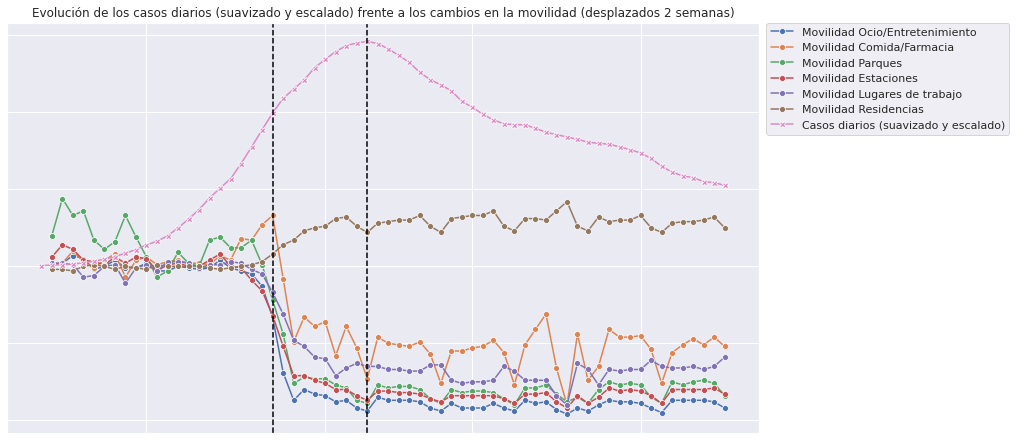

In [0]:
data = df[df['CCAA'] == 'Total'].copy()
data['CasosSmooth'] = GetMovingAverage(data, 'Casos/d', windowSize) / 50

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(14, 6))
labels = mobilityVariables + ['Casos diarios (suavizado y escalado)']

for variable in mobilityVariables:
    data[variable] = data[variable].shift(14)
    sns.lineplot(x='Fecha', y=variable, data=data, ax=axs, marker='o')
sns.lineplot(x='Fecha', y='CasosSmooth', data=data, ax=axs, marker='X')
axs.axvline(datetime(2020, 3, 27), color='black', ls='--')
axs.axvline(datetime(2020, 4, 5), color='black', ls='--')
axs.legend(labels=labels, bbox_to_anchor=(1.01, 1), borderaxespad=0)
axs.set(xticklabels=[], yticklabels=[])
axs.set_ylabel('')    
axs.set_xlabel('')
axs.set_title('Evolución de los casos diarios (suavizado y escalado) frente a los cambios en la movilidad (desplazados 2 semanas)');

En esta última visualización si que es posible ver una relación directa entre el descenso de la movilidad y el número de casos diarios. La gráfica se podría dividir en las tres partes que quedan delimitadas por las líneas verticales discontinuas negras:

1. En la primera sección del gráfico es posible apreciar cómo los niveles normales en la movilidad ocasionaron una gran subida en la cantidad de nuevos casos diarios.
2. La segunda sección se puede ver como el periodo necesario para que la reducción de los niveles de movilidad surtieran efecto en la cantidad de casos.
3. Por último, la tercera sección muestra cómo manteniendo los niveles de movilidad bajos la cantidad diaria de nuevos contagios se reduce con el tiempo.

## Predicción de casos y fallecidos diarios

En esta sección del notebook se intentará realizar una predicción sobre el número de nuevos casos y fallecidos diarios. Nuevamente, se utilizarán los datos a nivel nacional por simplicidad. Para evaluar la calidad de las predicciones realizadas se podrán utilizar los datos de cifras del COVID-19 descartados inicialmente por falta de datos sobre movilidad, es decir, los datos correspondientes al intervalo de días del 10 de Mayo al 17 de Mayo. Para la predicción se hará uso del modelo ARIMA.

### Parámetros ARIMA

Para entrenar un modelo ARIMA es necesario establecer el valor de los siguientes parámetros:

* _p_: _lag order_
* _d_: _differencing order_
* _q_: _order of moving average_

A la hora de realizar las predicciones, se explorarán varios valores con el objetivo de estudiar cómo afectan a la calidad de la predicción.

En primer lugar se llevará a cabo la comprobación de si las señales sobre las que se realizarán las predicciones son estacionarias. Aunque a partir de la visualización de las señales es posible deducir que no son estacionarias, se aplicará el _ADF (Augmented Dickey Fuller) test_ para comprobarlo. También se mostrarán las descomposiciones de ambas señales:

In [0]:
train = df[df['CCAA'] == 'Total'][['Casos/d', 'Fallecidos/d', 'Fecha']]
test = originalDf[(originalDf['CCAA'] == 'Total') & (originalDf['Fecha'] > lastDay)][['Casos/d', 'Fallecidos/d', 'Fecha']]
train.rename({'Casos/d': 'C', 'Fallecidos/d': 'F'}, axis=1, inplace=True)
test.rename({'Casos/d': 'C', 'Fallecidos/d': 'F'}, axis=1, inplace=True)
train.set_index('Fecha', inplace=True)
test.set_index('Fecha', inplace=True)
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)

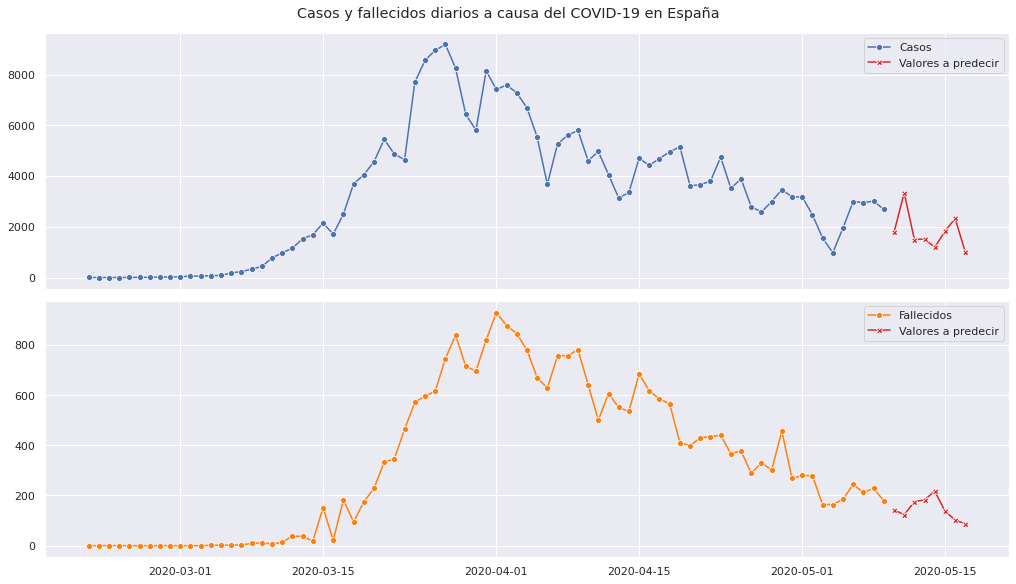

In [0]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(14, 8), sharex=True)
sns.lineplot(x=train.index, y='C', data=train, ax=axs[0], marker='o', label='Casos')
sns.lineplot(x=test.index, y='C', data=test, ax=axs[0], color='tab:red', marker='X', label='Valores a predecir')
sns.lineplot(x=train.index, y='F', data=train, ax=axs[1], marker='o', color='tab:orange', label='Fallecidos')
sns.lineplot(x=test.index, y='F', data=test, ax=axs[1], color='tab:red', marker='X', label='Valores a predecir')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
fig.suptitle('Casos y fallecidos diarios a causa del COVID-19 en España');

In [0]:
def ADFTest(timeseries, window=14, title='', showChart=True):
    rollingMean = timeseries.rolling(window).mean()
    rollingStd = timeseries.rolling(window).std()
    
    if showChart:
        fig, axs = plt.subplots(1, 1, figsize=(12,6), constrained_layout=True)
        sns.lineplot(data=timeseries, ax=axs, marker='o', label='Original')
        sns.lineplot(data=rollingMean, ax=axs, marker='o', color='tab:orange', label='Media móvil')
        sns.lineplot(data=rollingStd, ax=axs, marker='o', color='tab:green', label='Desviación típica móvil')
        fig.suptitle(title)
        plt.show()
    
    print('===============================')
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

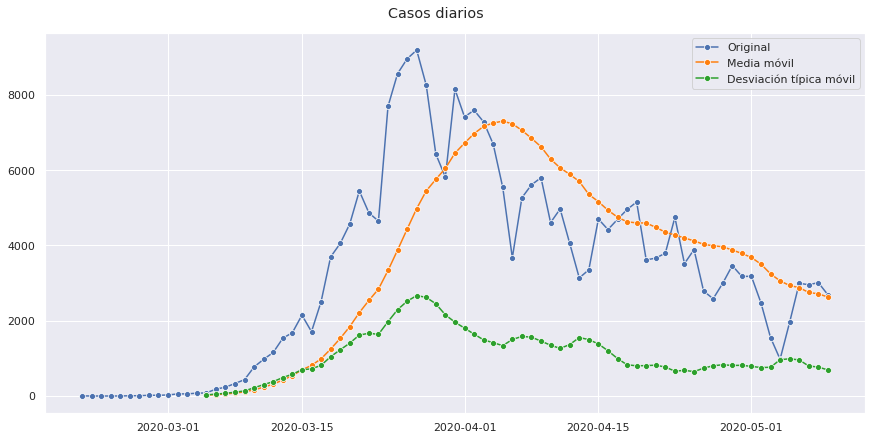

Results of Dickey-Fuller Test:
Test Statistic                -2.587
p-value                        0.096
Lags Used                      8.000
Number of Observations Used   70.000
Critical Value (1%)           -3.527
Critical Value (5%)           -2.904
Critical Value (10%)          -2.589
dtype: float64


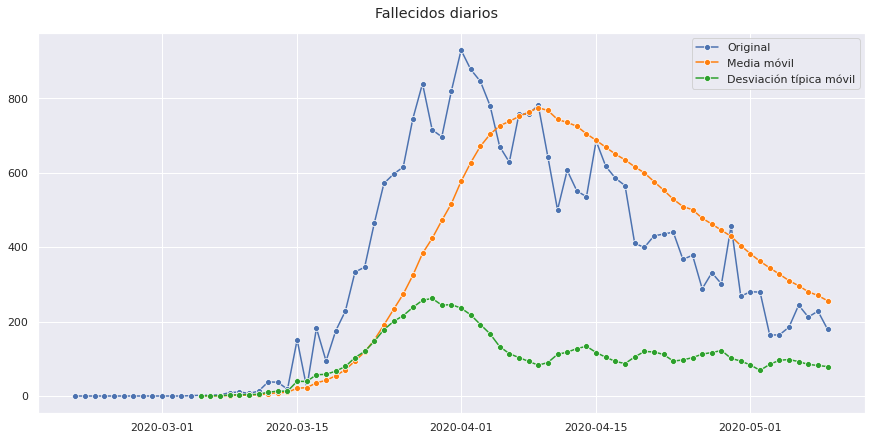

Results of Dickey-Fuller Test:
Test Statistic                -2.442
p-value                        0.130
Lags Used                      8.000
Number of Observations Used   70.000
Critical Value (1%)           -3.527
Critical Value (5%)           -2.904
Critical Value (10%)          -2.589
dtype: float64


In [0]:
ADFTest(train['C'], title='Casos diarios')
ADFTest(train['F'], title='Fallecidos diarios')

Para ambas señales, el estadístico del test _ADF_ es mayor que los _critical values_ por lo que no es posible rechazar la hipótesis nula, es decir, las señales no son estacionarias.

In [0]:
def DecomposeSignal(signal, title=''):
    decomposition = seasonal_decompose(signal)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    fig, axs = plt.subplots(4, 1, figsize=(10,12), sharex=True, constrained_layout=True)
    sns.lineplot(data=signal, ax=axs[0], marker='o', label='Original')
    sns.lineplot(data=trend, ax=axs[1], marker='o', color='tab:orange', label='Tendencia')
    sns.lineplot(data=seasonal, ax=axs[2], marker='o', color='tab:green', label='Estacionalidad')
    sns.lineplot(data=residual, ax=axs[3], marker='o', color='tab:red', label='Residuos')
    fig.suptitle(title)
    
    return trend, seasonal, residual

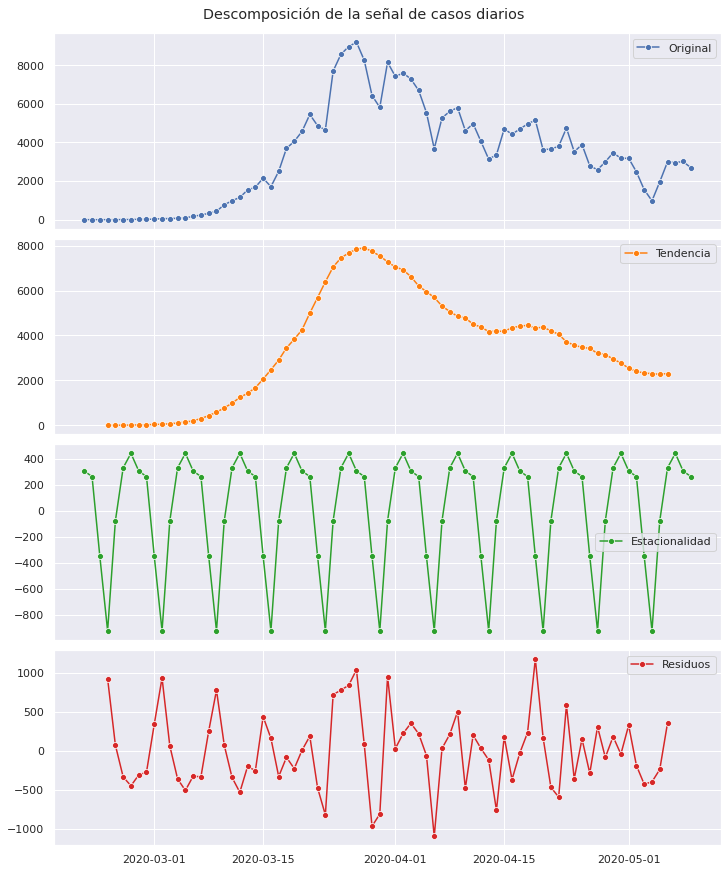

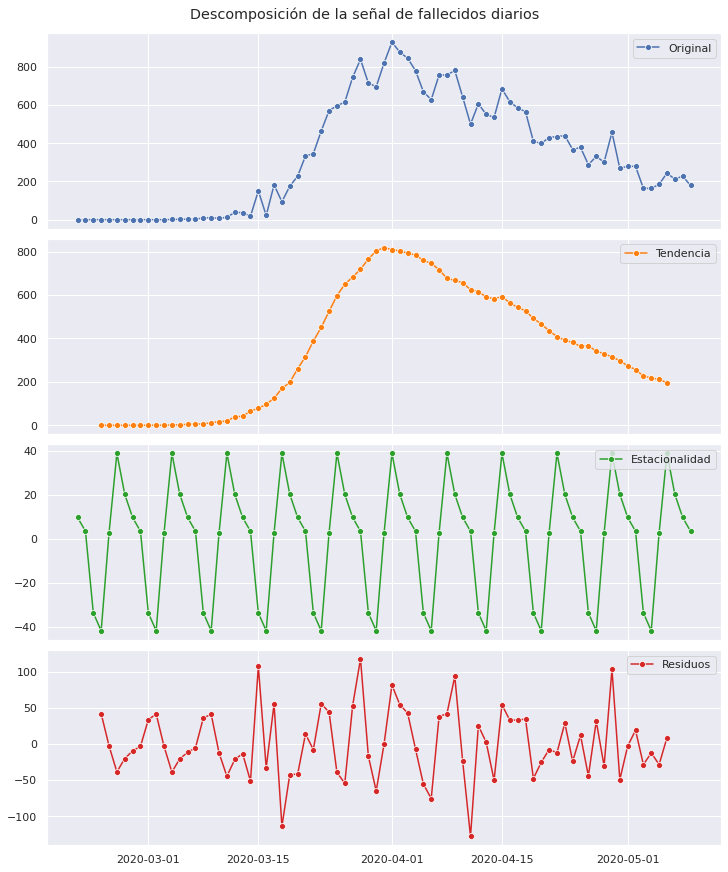

In [0]:
DecomposeSignal(train['C'], 'Descomposición de la señal de casos diarios')
DecomposeSignal(train['F'], 'Descomposición de la señal de fallecidos diarios');

A partir de la decomposición de las señales queda claro que se necesitará aplicar como mínimo una diferencia para eliminar los efectos de tendencia o estacionalidad.

In [0]:
firstOrderCDiff = train['C'].diff().dropna()
secondOrderCDiff = firstOrderCDiff.diff().dropna()
firstOrderFDiff = train['F'].diff().dropna()


ADFTest(firstOrderCDiff, showChart=False)
ADFTest(secondOrderCDiff, showChart=False)
ADFTest(firstOrderFDiff, showChart=False)

Results of Dickey-Fuller Test:
Test Statistic                -1.824
p-value                        0.369
Lags Used                      6.000
Number of Observations Used   71.000
Critical Value (1%)           -3.526
Critical Value (5%)           -2.903
Critical Value (10%)          -2.589
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -10.843
p-value                         0.000
Lags Used                       5.000
Number of Observations Used    71.000
Critical Value (1%)            -3.526
Critical Value (5%)            -2.903
Critical Value (10%)           -2.589
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -10.112
p-value                         0.000
Lags Used                       0.000
Number of Observations Used    77.000
Critical Value (1%)            -3.518
Critical Value (5%)            -2.900
Critical Value (10%)           -2.587
dtype: float64


Para convertir la señal de casos diarios en estacionaria han sido necesarias 2 diferencias, mientras que para hacer lo propio con la señal de fallecidos diarios se ha aplicado una única diferencia. Nuevamente, se ha utilizado el test _ADF_ para comprobar si las señales obtenidas eran estacionarias. A continuación se mostrarán las funciones de autocorrelación y autocorrelación parcial de las señales obtenidas al aplicar las diferencias:

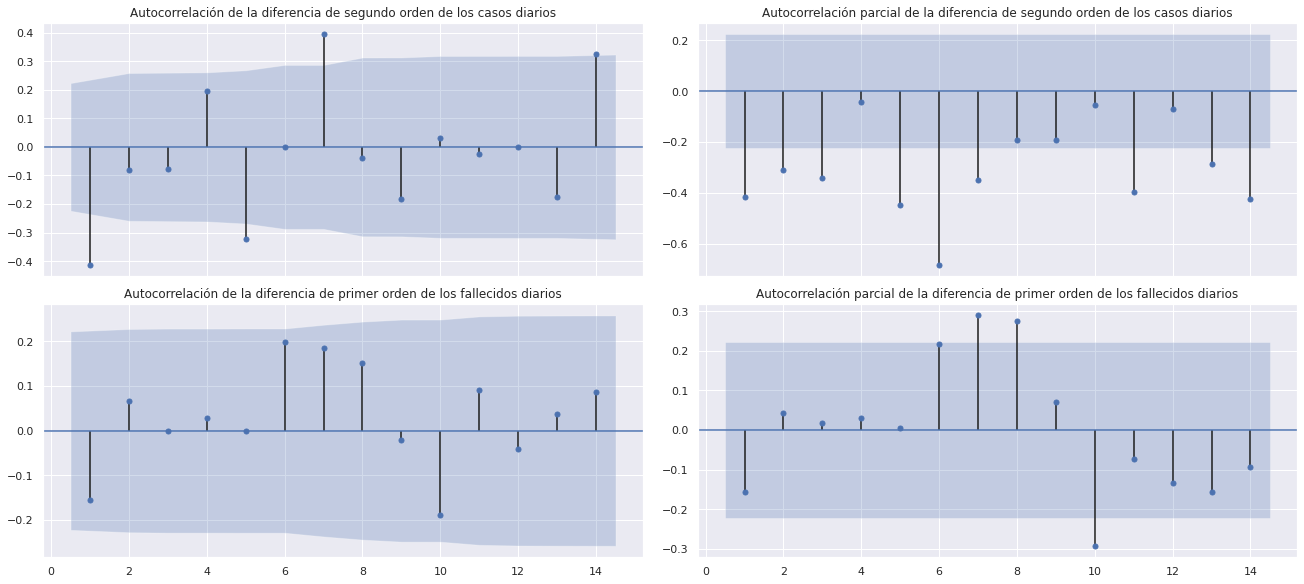

In [0]:
lags = 14

fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, constrained_layout=True)
plot_acf(secondOrderCDiff, zero=False, lags=lags, ax=axs[0][0], title='Autocorrelación de la diferencia de segundo orden de los casos diarios');
plot_pacf(secondOrderCDiff, zero=False, lags=lags, ax=axs[0][1], title='Autocorrelación parcial de la diferencia de segundo orden de los casos diarios');
plot_acf(firstOrderFDiff, zero=False, lags=lags, ax=axs[1][0], title='Autocorrelación de la diferencia de primer orden de los fallecidos diarios');
plot_pacf(firstOrderFDiff, zero=False, lags=lags, ax=axs[1][1], title='Autocorrelación parcial de la diferencia de primer orden de los fallecidos diarios');

### Modelo ARIMA

Las siguientes celdas de código definen funciones auxiliares utilizadas durante el proceso de construcción y evaluación del modelo ARIMA:

* _GridSearch_: se encarga de entrenar y evaluar de manera iterativa un modelo ARIMA con distintos parámetros de entrada. La función devuelve un dataframe con el valor de la métrica RMSE para cada tupla de parámetros.
* _EvaluateModel_: crea un modelo ARIMA con los parámetros especificados, lo evalua y muestra una gráfica con las predicciones realizadas y el valor de la métrica RMSE.
* _PlotModelResiduals_: muestra gráficas sobre los residuos de un modelo entrenado.

In [0]:
def GridSearch(params):
    results = []
    for d in params['d']:
        for p in params['p']:
            for q in params['q']:
                model = ARIMA(params['ts'], order=(p, d, q))
                result = model.fit()
                forecast = result.get_forecast('2020-05-17').summary_frame()
                rmse = mean_squared_error(test[params['variable']], forecast['mean'], squared=False)

                results.append({'p': p, 'd': d, 'q': q, 'rmse': rmse})

    resultsDf = pd.DataFrame(results, columns=['p', 'd', 'q', 'rmse'])
    
    return resultsDf

In [0]:
def EvaluateModel(params):
    model = ARIMA(train[params['variable']], order=params['order'])
    modelFit = model.fit()
    forecast = modelFit.get_forecast('2020-05-17').summary_frame()
    label = params['label']
    order = params['order']
    
    rmse = mean_squared_error(test[params['variable']], forecast['mean'], squared=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), constrained_layout=True)
    sns.lineplot(data=train[params['variable']], marker='o', label=label.capitalize())
    sns.lineplot(data=pd.concat([modelFit.predict(), forecast['mean']]), marker='X', label='Predicho')
    sns.lineplot(x=test.index, y=params['variable'], data=test, color='tab:green', marker='^', label='Valores reales')
    ax.set_ylabel(label.capitalize())
    ax.set_title(f'Predicción de {label} del modelo ARIMA {order}. RMSE = {rmse}');
    
    return model, modelFit

In [0]:
def PlotModelResiduals(modelFit):
    residuals = pd.DataFrame(modelFit.resid)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    residuals.plot(title='Residuos', ax=ax[0])
    residuals.plot(kind='kde', title='Densidad', ax=ax[1])
    ax[1].set_ylabel('')
    plt.show()

#### Predicción de casos diarios

En primer lugar se invocará a la función _GridSearch_ para conocer la tupla de parámetros con las que mejores predicciones se obtienen:

In [0]:
params = {
    'variable': 'C',
    'ts': train['C'],
    'd': [0, 1, 2],
    'p': [0, 1, 2, 3, 4],
    'q': [0, 1, 2, 3, 4]
}
GridSearch(params).sort_values(['rmse']).head(n=10)

,p,d,q,rmse
60,2,2,0,661.522
55,1,2,0,678.892
38,2,1,3,898.283
17,3,0,2,947.022
50,0,2,0,982.150
74,4,2,4,1051.328
67,3,2,2,1056.020
44,3,1,4,1059.141
37,2,1,2,1068.823
39,2,1,4,1089.760


A continuación se muestran las predicciones realizadas con las 3 tuplas de parámetros que mejor valor RMSE obtuvieron, es decir:

* (2, 2, 0)
* (1, 2, 0)
* (2, 1, 3)

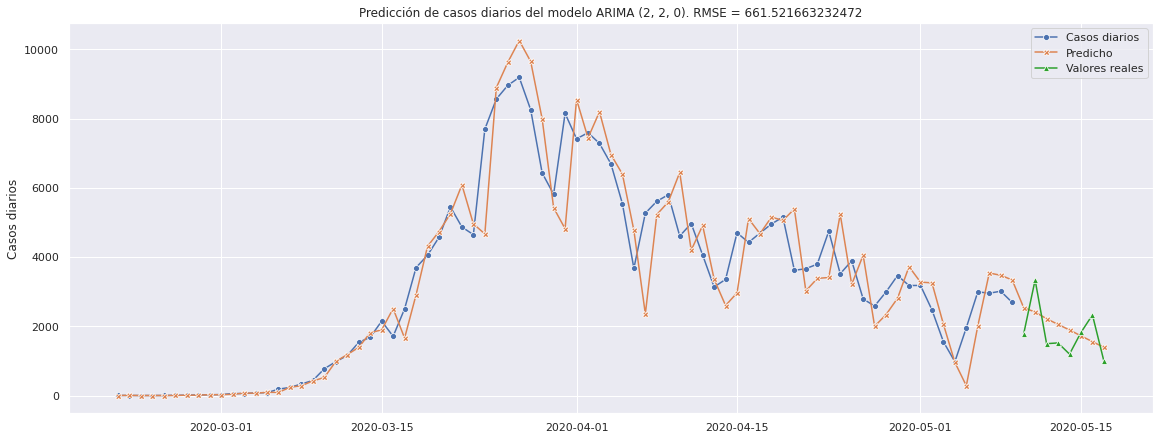

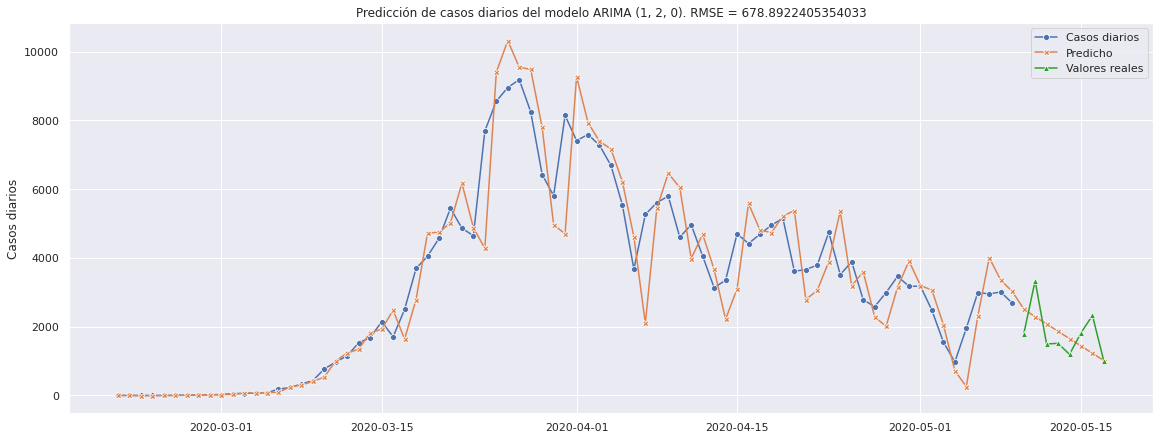

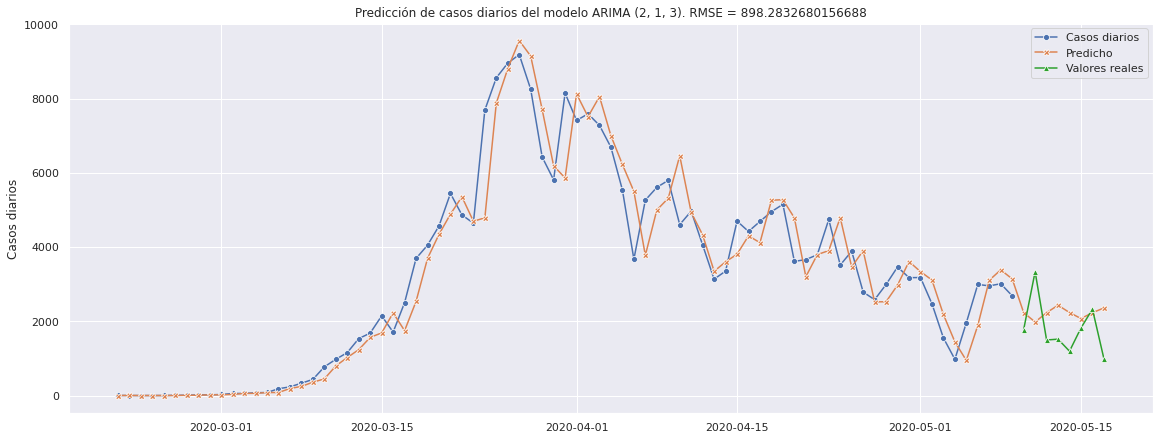

In [0]:
cModel, cModelFit = EvaluateModel({'variable': 'C', 'order': (2, 2, 0), 'label': 'casos diarios' })
_, _ = EvaluateModel({'variable': 'C', 'order': (1, 2, 0), 'label': 'casos diarios' })
_, _ = EvaluateModel({'variable': 'C', 'order': (2, 1, 3), 'label': 'casos diarios' })

Atendiendo tanto al valor de la métrica RMSE, como a la gráfica de las predicciones, es posible advertir que los modelos construidos con las dos primeras tuplas de parámetros realizan una predicción más ajustada y por lo tanto, son modelos de mejor calidad. Ambos modelos tienen en común el valor 0 del parámetro _q_, esto implica que "la parte de de media móvil del modelo se suprime".

Por último, se analizarán los residuos del mejor de los modelos obtenidos para intentar determinar si dicho modelo ha sido capaz de "capturar" la información y los patrones de los datos:

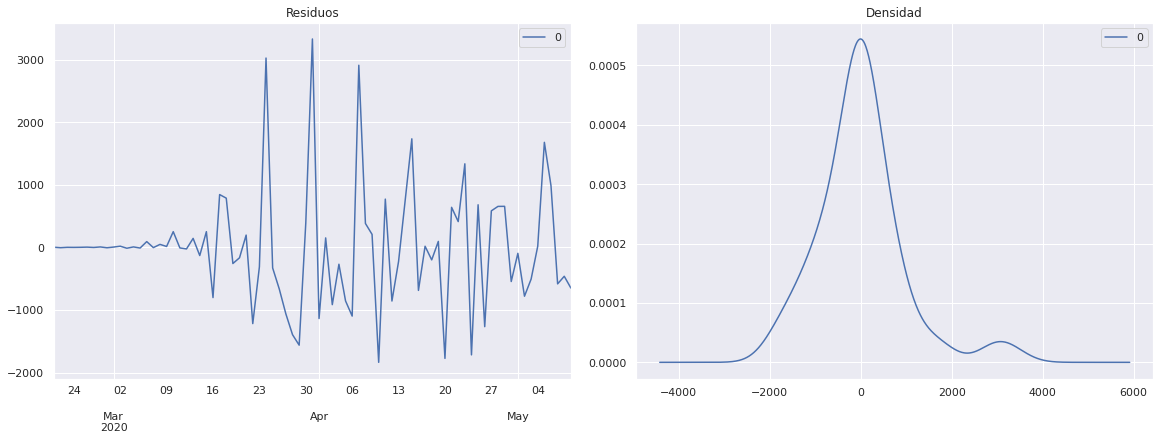

In [0]:
PlotModelResiduals(cModelFit)

La función de densidad se asemeja a una normal y la media parece ser muy cercana al valor 0. La gráfica de valores no parece mostrar ninguna tendencia o patrón por lo que se puede concluir que el modelo tiene una cierta calidad.

#### Predicción de fallecidos diarios

En esta subsección se llevarán a cabo los mismos pasos seguidos en la subsección previa:

In [0]:
params = {
    'variable': 'F',
    'ts': train['F'],
    'd': [0, 1, 2],
    'p': [0, 1, 2, 3, 4],
    'q': [0, 1, 2, 3, 4]
}
GridSearch(params).sort_values(['rmse']).head(n=10)

,p,d,q,rmse
71,4,2,1,36.798
53,0,2,3,37.966
66,3,2,1,39.302
51,0,2,1,39.310
63,2,2,3,39.816
18,3,0,3,39.973
16,3,0,1,40.120
57,1,2,2,40.156
22,4,0,2,40.169
21,4,0,1,40.302


A continuación se muestran las predicciones realizadas con las 3 tuplas de parámetros que mejor valor RMSE obtuvieron, es decir:

* (4, 2, 1)
* (0, 2, 3)
* (3, 2, 1)

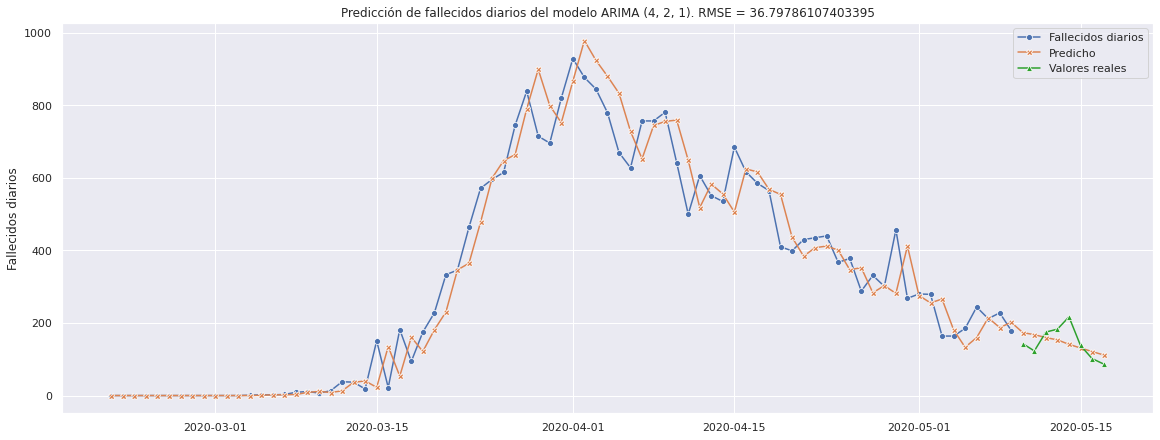

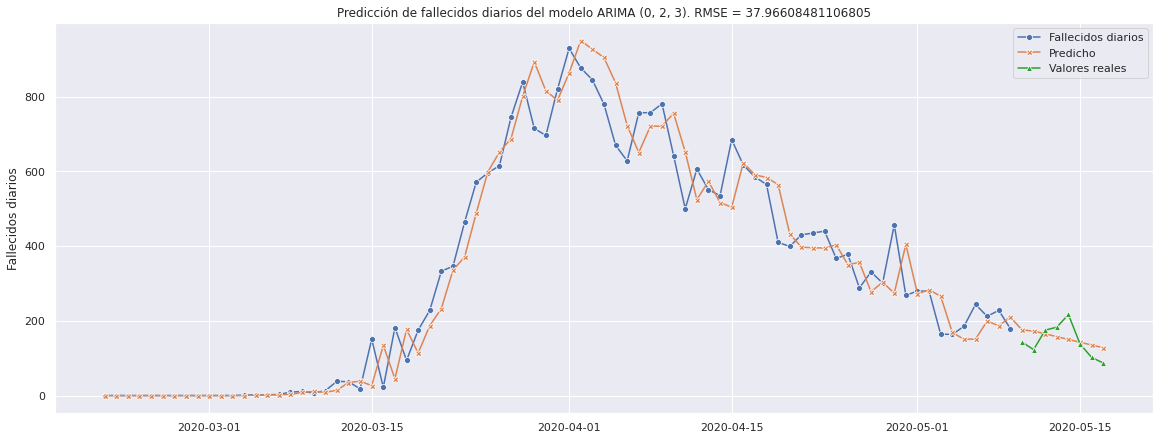

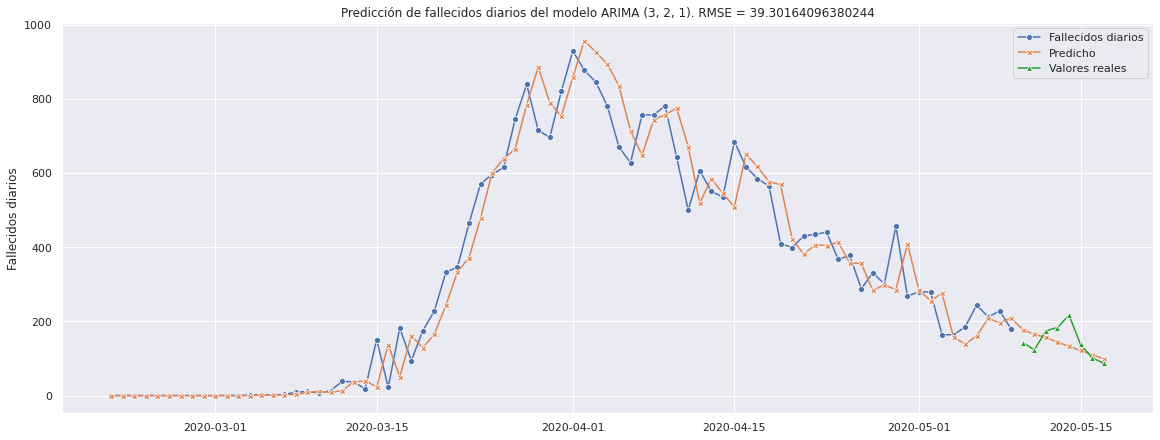

In [0]:
fModel, fModelFit = EvaluateModel({'variable': 'F', 'order': (4, 2, 1), 'label': 'fallecidos diarios' })
_, _ = EvaluateModel({'variable': 'F', 'order': (0, 2, 3), 'label': 'fallecidos diarios' })
_, _ = EvaluateModel({'variable': 'F', 'order': (3, 2, 1), 'label': 'fallecidos diarios' })

Resulta sorprendente que las 5 mejores configuraciones de parámetros compartan el valor 2 para el parámetro _d_. En secciones previas del notebook se halló la diferencia de primer orden de la señal de fallecidos diarios y mediante el test _ADF_ se pudo comprobar que ya era estacionaria. Por precaución de no incurrir en el fenómeno conocido cómo _overdifferencing_ se creyó que el mejor valor posible para el parámetro _d_ sería 1. Mediante la experimentación se ha podido ver que el mejor valor posible (de entre los estudiados) es 2.

Por último, se analizarán los residuos del mejor de los modelos obtenidos para intentar determinar si dicho modelo ha sido capaz de "capturar" la información y los patrones de los datos:

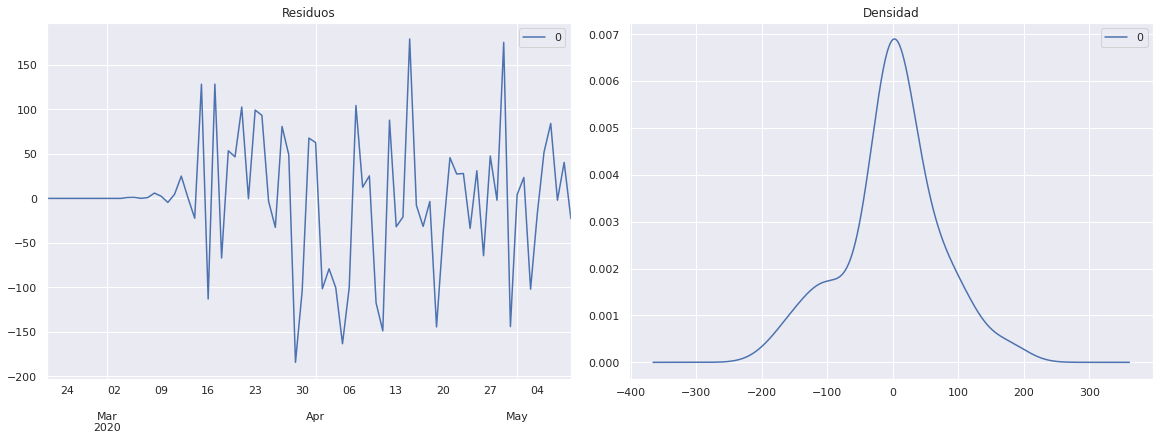

In [0]:
PlotModelResiduals(fModelFit)

Nuevamente es posible apreciar cómo la función de densidad se asemeja a una normal y la media es prácticamente 0. La gráfica de valores tampoco parece mostrar ninguna tendencia o patrón por lo que puede concluirse que el modelo ha logrado extraer la información de los datos.

## Conclusiones

A modo de conclusión, cabe resaltar que a pesar de que las labores de análisis de datos realizadas a lo largo del notebook han sido de un nivel básico, han servido de apoyo a los conocimientos teóricos adquiridos durante la parte presencial de la asignatura. Además, dichos conocimientos se han podido aplicar sobre un gran problema real y de actualidad. 

Las predicciones realizadas no son de muy buena calidad, se ha llevado a cabo una aproximación muy ingenua pero al menos se han podido obtener y visualizar algunos resultados. Los modelos construidos parecen haber sido capaces de acertar con la tendencia de las series temporales al realizar las predicciones.

Como posible línea futura, hubiera sido interesante incorporar los datos sobre movilidad poblacional al proceso de obtención de un modelo de predicción. Al tratarse de contagios de una enfermedad, a priori, este tipo de datos debería estar bastante relacionado con la cantidad de casos diarios.

## Referencias

En este listado se muestran algunons de los recursos de más utilidad utilizados para la realización de la práctica:

* [Datos COVID-19 España](https://github.com/datadista/datasets/tree/master/COVID%2019)
* [Informes de Movilidad Local sobre el COVID-19](https://www.google.com/covid19/mobility/index.html?hl=es)
* [Forecasting: Principles and Practice - Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp2/)
* [Stationarity and differencing](https://otexts.com/fpp2/stationarity.html)
* [Residual diagnostics](https://otexts.com/fpp2/residuals.html)
* [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)
* [A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python and R)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
* [A Gentle Introduction to Handling a Non-Stationary Time Series in Python](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)
* [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
* [Identifying the order of differencing in an ARIMA model](https://people.duke.edu/~rnau/411arim2.htm)
* [Identifying the numbers of AR or MA terms in an ARIMA model](https://people.duke.edu/~rnau/411arim3.htm)
* [Summary of rules for identifying ARIMA models](https://people.duke.edu/~rnau/arimrule.htm)
* [statsmodel](https://www.statsmodels.org/stable/index.html)
* [ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)